This file contains python code for sure ind screening from Jianqing Fan

In [2]:
import sys
sys.path.append("../mypkg")

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from scipy.stats import pearsonr
from numbers import Number
import multiprocessing as mp

from easydict import EasyDict as edict
from tqdm import trange
from scipy.io import loadmat
from pprint import pprint

plt.style.use('ggplot')
plt.rcParams["savefig.bbox"] = "tight"

In [4]:
import importlib
import optimization.opt
importlib.reload(optimization.opt)

<module 'optimization.opt' from '/data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/optimization/opt.py'>

In [5]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_psd
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse
from utils.functions import logit_fn
from utils.misc import save_pkl
from splines import obt_bsp_basis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_linear_fn
from optimization.opt import optimization

from penalties.scad_pen import SCAD
from models.logistic_model import LogisticModel
from models.linear_model import LinearModel


In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

## Param and fns

### Params

### Fns

In [24]:
def _gen_simu_data_all(seed, paras):
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
    
    simu_psd = gen_simu_psd(_paras.n, _paras.d, 10)
    #simu_psd = torch.randn(_paras.n, _paras.d, _paras.npts).numpy()
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_psd[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    
    # Y 
    rvs = np.random.rand(_paras.n)
    Y = lin_term + np.random.randn(_paras.n)*np.sqrt(_paras.sigma2)
    
    # To torch
    X = torch.tensor(simu_psd) # n x d x npts
    Z = torch.tensor(simu_covs) # n x q
    Y = torch.tensor(Y)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    return all_data

## Test

### When model is correct

In [25]:
np.random.seed(0)
paras = edict(def_paras.copy())

# Others
paras.num_rep = 20
paras.ns = [100, 300, 900, 2700, 8100, 24300]
paras.can_lams = [1e-1, 3e-1, 1e0, 3e0, 9e0, 3e1]
paras.can_Ns = [5, 10, 15, 20]
paras.ind_freq = np.linspace(1, 40, 40) # freqs
paras.init_noise_sd = 0 # the sd of the noise added to the true value for initial values

# generating dataset
paras.n = 5000 # num of data obs to be genareted
paras.npts = 40 # num of pts to evaluate X(s)
paras.d = 1 # num of ROIs
paras.q = 5 # num of other covariates
paras.sigma2 = 1 # variance of the error
#paras.types_ = ["int"]
paras.types_ = ["int", 2, 2, "c", "c"]

# b-spline
paras.N = 20# int(3*paras.n**(1/paras.ord/2)) # num of basis for bsp
paras.x = np.linspace(0, 1, paras.npts)
paras.basis_mat = torch.DoubleTensor(obt_bsp_basis_Rfn_wrapper(paras.x, paras.N, paras.ord))
assert paras.N == paras.basis_mat.shape[1]
print(f"The number of B-spline basis is {paras.N:.0f}.")

# True parameters
#paras.alp_GT = np.array([5])
paras.alp_GT = np.array([5, 1, -2, 3, -4])

paras.fourier_basis = fourier_basis_fn(paras.x)
paras.beta_GT = paras.fourier_basis @ coef_fn(0.5) * 0
paras.beta_GT = paras.beta_GT.reshape(-1, 1)
#
paras.Gam_est = (np.linalg.inv(paras.basis_mat.numpy().T 
                               @ paras.basis_mat.numpy()) 
                               @ paras.basis_mat.numpy().T 
                               @ paras.beta_GT)

# optimization
paras.Rmin = 2*(np.linalg.norm(paras.Gam_est/np.sqrt(paras.N), axis=0).sum() + np.abs(paras.alp_GT).sum())
paras.sel_idx = np.arange(2, paras.d) # M^c set
paras.num_cv_fold = 5
paras.Rfct = 2

The number of B-spline basis is 20.


In [26]:
dat = _gen_simu_data_all(1, paras)

In [27]:
X, Y, Z = dat.X, dat.Y, dat.Z
_paras = edict(paras.copy())

ix = 0
cur_X = X[:, ix, :].unsqueeze(-1)
tmp_BX = (cur_X * _paras.basis_mat).mean(axis=1)
vec_p2 = tmp_BX*np.sqrt(_paras.N)
vec_p = torch.cat([Z, vec_p2], dim=1)
    
right_vec = torch.sum(vec_p * Y.unsqueeze(-1), axis=0)
left_mat = torch.sum(vec_p.unsqueeze(-1) * vec_p.unsqueeze(1), axis=0)
cur_gam = torch.linalg.solve(left_mat, right_vec)[paras.q:] * np.sqrt(paras.N)
cur_all = torch.linalg.solve(left_mat, right_vec)[:paras.q]
beta_est = paras.basis_mat @ cur_gam
cur_all

tensor([ 4.9317,  1.0162, -2.0151,  3.0023, -4.0106])

In [28]:
torch.norm(beta_est)

tensor(12.6765)

In [29]:
int_part = np.sum(beta_est.numpy().reshape(1, -1)* X.numpy()[:, :, :], axis=1).mean(axis=1)
np.mean(int_part**2)

0.007666854485178513

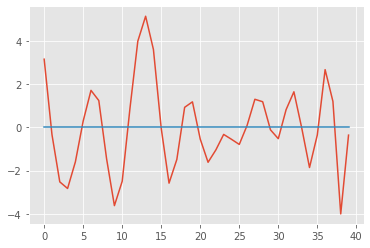

In [30]:
plt.plot(beta_est)
plt.plot(paras.beta_GT)

### When SIS

In [8]:
np.random.seed(0)
paras = edict(def_paras.copy())

# Others
paras.num_rep = 20
paras.ns = [100, 300, 900, 2700, 8100, 24300]
paras.can_lams = [1e-1, 3e-1, 1e0, 3e0, 9e0, 3e1]
paras.can_Ns = [5, 10, 15, 20]
paras.ind_freq = np.linspace(1, 40, 40) # freqs
paras.init_noise_sd = 0 # the sd of the noise added to the true value for initial values

# generating dataset
paras.n = 5000 # num of data obs to be genareted
paras.npts = 40 # num of pts to evaluate X(s)
paras.d = 68 # num of ROIs
paras.q = 5 # num of other covariates
paras.sigma2 = 1 # variance of the error
paras.types_ = ["int", 2, 2, "c", "c"]
#paras.types_ = ["int"]

# b-spline
paras.N = 20# int(3*paras.n**(1/paras.ord/2)) # num of basis for bsp
paras.x = np.linspace(0, 1, paras.npts)
paras.basis_mat = torch.DoubleTensor(obt_bsp_basis_Rfn_wrapper(paras.x, paras.N, paras.ord))
assert paras.N == paras.basis_mat.shape[1]
print(f"The number of B-spline basis is {paras.N:.0f}.")

# True parameters
paras.alp_GT = np.array([5, 1, -2, 3, -4])
#paras.alp_GT = np.array([5])

# first way
#beta_type_GT = [fn1, fn2, fn2] + [zero_fn]*(paras.d-3-2) + [fn1, fn2]
#paras.beta_GT = np.array([_fn(paras.x) for _fn in beta_type_GT]).T
# second way, fourier basis
paras.fourier_basis = fourier_basis_fn(paras.x)
paras.fourier_basis_coefs = ([coef_fn(0.1), coef_fn(0.3), coef_fn(0.5)] + 
                             [np.zeros(50)] * (paras.d-3-2) +
                             [coef_fn(0.7), coef_fn(0.9)]
                             )
paras.fourier_basis_coefs = np.array(paras.fourier_basis_coefs).T * 5
paras.beta_GT = paras.fourier_basis @ paras.fourier_basis_coefs
#
paras.Gam_est = (np.linalg.inv(paras.basis_mat.numpy().T 
                               @ paras.basis_mat.numpy()) 
                               @ paras.basis_mat.numpy().T 
                               @ paras.beta_GT)

# optimization
paras.Rmin = 2*(np.linalg.norm(paras.Gam_est/np.sqrt(paras.N), axis=0).sum() + np.abs(paras.alp_GT).sum())
paras.sel_idx = np.arange(2, paras.d) # M^c set
paras.num_cv_fold = 5
paras.Rfct = 2

The number of B-spline basis is 20.


In [9]:
dat = _gen_simu_data_all(0, paras)

In [413]:

def SIS_linear(Y, X, Z, paras, keep_ratio=0.3):
    """The function is to do the sure ind screening when d (num of ROIs) is large under linear model
       Ref to Fan_and_Lv_JRSSB_2008
       args:
            Y: Response
            X: The psd 
            Z: Covariates
            paras: Other parameters
            keep_ratio: The ratio between the keeped rois and all rois
    """
    _paras = edict(paras.copy())
    
    num_kp = int(np.round(_paras.d*keep_ratio, 0))
    
    SIS_gams = []
    for ix in range(_paras.d):
        cur_X = X[:, ix, :].unsqueeze(-1)
        tmp_BX = (cur_X * _paras.basis_mat).mean(axis=1)
        vec_p2 = tmp_BX*np.sqrt(_paras.N)
        vec_p = torch.cat([Z, vec_p2], dim=1)
        
        right_vec = torch.sum(vec_p * Y.unsqueeze(-1), axis=0)
        left_mat = torch.sum(vec_p.unsqueeze(-1) * vec_p.unsqueeze(1), axis=0)
        cur_gam = torch.linalg.solve(left_mat, right_vec)[_paras.q:] * np.sqrt(_paras.N)
        SIS_gams.append(cur_gam.numpy())
    SIS_gams = np.array(SIS_gams)
    SIS_betas = _paras.basis_mat.numpy() @ SIS_gams.T
    norm_vs =  np.sqrt(np.mean(SIS_betas**2, axis=0))
    keep_idxs = np.argsort(-norm_vs)[:num_kp]
    return keep_idxs, norm_vs

In [10]:
X, Y, Z = dat.X, dat.Y, dat.Z
SIS_linear(Y, X, Z, paras, 0.3)

(array([67,  0, 66,  2, 48, 18, 38,  1, 19, 51,  9, 29, 36, 21, 42, 52, 35,
        20, 47, 56]),
 array([10.04072826,  6.07242904,  6.64047794,  4.08619213,  3.79271146,
         3.94283349,  4.83781116,  4.75978521,  4.85295388,  5.86878253,
         4.79664168,  3.49568471,  4.4954055 ,  3.56828191,  4.59338282,
         4.9854682 ,  3.66615283,  3.99828962,  6.2832365 ,  6.0247902 ,
         5.13628813,  5.44641278,  2.73078377,  4.51173739,  4.29656783,
         4.54447257,  4.35723135,  4.99381266,  4.61027356,  5.81197583,
         3.61287697,  3.72331175,  4.98511664,  4.45792044,  4.59514774,
         5.30187279,  5.66880008,  4.26832851,  6.20632656,  4.06622298,
         3.72030059,  3.14232352,  5.44404749,  4.08900446,  4.79056298,
         4.93822693,  3.78497863,  5.11166118,  6.32538595,  4.03092089,
         3.20445077,  6.01364093,  5.37095886,  4.42416514,  3.75284975,
         4.57934396,  5.04037465,  3.71900828,  4.24595837,  4.86958067,
         3.0723421 ,  3.96